#### Just add path to test-dataset in 2nd cell here and run all cells to get AUC and Accuracy metrics in the last cell

In [26]:
import numpy as np
from matplotlib import pyplot as plt
import librosa
import librosa.display
import skimage.io
import os
import cv2
from pydub import AudioSegment
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization, Flatten, Dropout, ZeroPadding2D, concatenate, Input
from keras.models import Model, Sequential
from keras import regularizers

In [27]:
# "C:\Users\Dhruv Sharma\Desktop\Dhruv\lead\Projects\Mosaic23\Test\Test"

In [28]:
testDB = input("Enter path to dataset: ")

Enter path to dataset: C:\Users\Dhruv Sharma\Desktop\Dhruv\lead\Projects\Mosaic23\Test\Test


In [29]:
test_files = os.listdir(testDB)

In [30]:
wav_files = []
txt_files = []

for trfile in test_files:
    if trfile[-3:] == "txt":
        txt_files.append(trfile)
    elif trfile[-3:] == "wav":
        wav_files.append(trfile)

In [31]:
breathing_cycles = {}
# crackle_wheeze = {}

for txfile in txt_files:
    txpath = os.path.join(testDB, txfile)
    t = open(txpath, 'r')
    content = t.readlines()
    breathing_cycles[txfile[:-4]] = []
#     crackle_wheeze[txfile[:-4]] = []
    
    for line in content:
        data = line[:-1].split("\t")
        breathing_cycles[txfile[:-4]].append((data[0], data[1]))
#         crackle_wheeze[txfile[:-4]].append((data[2], data[3]))

In [32]:
os.mkdir("test_parted_audfiles")

for wfile in wav_files:
    wf_path = os.path.join(testDB, wfile)
    bcs = breathing_cycles[wfile[:-4]]
#     cws = crackle_wheeze[wfile[:-4]]
    i = 0
    
    for bc in bcs:
        i += 1
        start = float(bc[0]) * 1000
        end = float(bc[1]) * 1000
        
        AS = AudioSegment.from_wav(wf_path)
        AS = AS[start: end]
        AS.export("test_parted_audfiles/" + wfile[:-4] + "{}".format(i) + ".wav", format = "wav")

In [33]:
part_wav_files = os.listdir("test_parted_audfiles")

In [34]:
extra_feats = {}
cls = {'Ar': 0, 'Tc': 1, 'Al': 2, 'Pl': 3, 'Pr': 4, 'Ll': 5, 'Lr': 6}
re = {'LittC2SE': 0, 'Meditron': 1, 'Litt3200': 2, 'AKGC417L': 3}

for pwfile in part_wav_files:
    pwpath = os.path.join(testDB, pwfile)
    extra_feats[pwfile] = []
    
    extra_feats[pwfile].extend([cls[pwfile[8: 10]], re[pwfile[14: 22]]])

In [35]:
hard_feats = list(extra_feats.values())

In [36]:
part_wav_files

['133_2p3_Al_mc_AKGC417L1.wav',
 '133_2p3_Al_mc_AKGC417L2.wav',
 '133_2p3_Al_mc_AKGC417L3.wav',
 '133_2p3_Al_mc_AKGC417L4.wav']

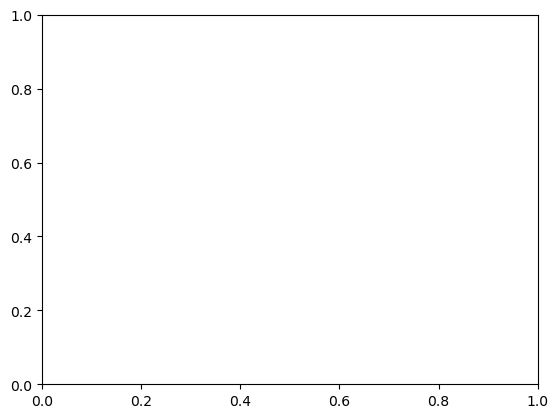

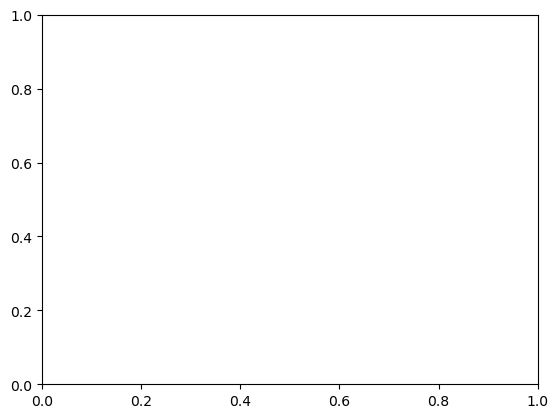

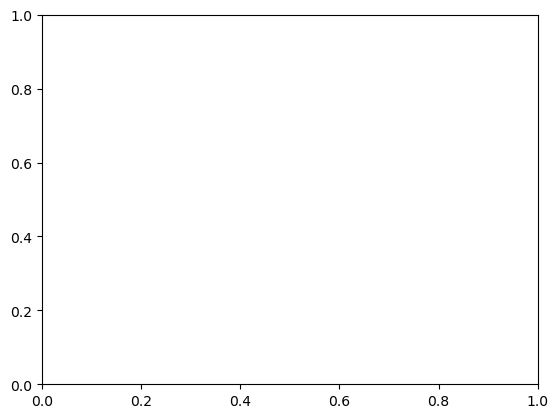

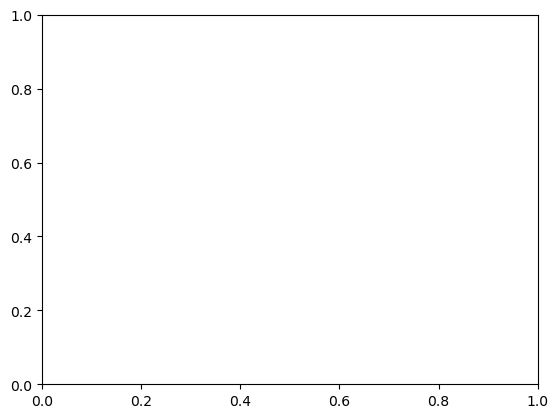

In [37]:
# making the spectrograms of the parted audiofiles
os.mkdir("test_parted_spectrograms")

def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

spectrograms = []
srs = []

for pwfile in part_wav_files:
    pwf_path = os.path.join("test_parted_audfiles", pwfile)
    aud, sr = librosa.load(pwf_path)
    
    S = librosa.feature.melspectrogram(y=aud, sr=sr, n_mels=128, fmax=8000, hop_length=512)
    
    fig, ax = plt.subplots()
    S_dB = librosa.power_to_db(S, ref=np.max)
    S_dB = scale_minmax(S_dB, 0, 255).astype(np.uint8)
    S_dB = np.flip(S_dB, axis = 0)
    S_dB = 255 - S_dB
    S_dB = cv2.resize(S_dB, (128, 128), interpolation = cv2.INTER_CUBIC)

    skimage.io.imsave("test_parted_spectrograms/" + pwfile[:-4] + "spec.png", S_dB)

In [38]:
pspecs = os.listdir("test_parted_spectrograms")

In [39]:
X_specs = []
# Y_labels = []

for pspec in pspecs:
    pspec_img = cv2.imread(os.path.join("test_parted_spectrograms", pspec))
    X_specs.append(pspec_img)

# for sfile in wav_files:
# #     cws = crackle_wheeze[sfile[:-4]]
#     for cw in cws:
#         Y_labels.append(np.array(cw).astype("float32"))

In [40]:
# Normalizing the data
for i in range(len(X_specs)):
    X_specs[i] = X_specs[i] / 255.0
    X_specs[i] = X_specs[i].reshape(X_specs[i].shape[0:3])
    X_specs[i] = np.array(X_specs[i].astype("float32"))
    
#     Y_labels[i] = Y_labels[i].reshape(Y_labels[i].shape[0: 2])

In [41]:
X_test = list(zip(X_specs, hard_feats))

In [42]:
test_hard = []
test_x = []

for e in X_test:
    test_hard.append(e[1])
    test_x.append(e[0])
    
test_x = np.array(test_x)
test_hard = np.array(test_hard)

In [43]:
# Y_test = np.array(Y_labels)

In [44]:
def conv_block():
    return keras.Sequential([
        ZeroPadding2D(padding = (1, 1)),
        Conv2D(64, 3, padding = "valid", activation = "ReLU"),
        BatchNormalization(axis = -1),
        MaxPool2D(pool_size = 2)
    ])

inputs = Input(shape = (128, 128, 3))
hard_feats = Input(shape = (1, ))
x = conv_block()(inputs)
x = conv_block()(x)
x = conv_block()(x)
x = conv_block()(x)
x = Flatten()(x)
x = Dense(32)(x)
x = concatenate([x, hard_feats])
x = BatchNormalization(axis = -1)(x)
x = Dense(2, activation = "sigmoid")(x)

test_model = Model(inputs = [inputs, hard_feats], outputs = [x])

In [45]:
optimizer = keras.optimizers.SGD(lr = 0.01)

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [46]:
test_model.compile(optimizer = optimizer, loss = "BinaryCrossentropy", metrics = ["AUC", "accuracy"])

#### Loading model parameters from model file

In [47]:
test_model.load_weights("live_model1.pt")

In [48]:
# evaluating on basis of both accuracy and Area Under ROC Curve

def get_test_metrics():
    obtained_metrics = test_model.evaluate([test_x, test_hard[:, 0]], np.array(Y_test), batch_size = 32, verbose = 0)

    print("Obtained Metrics are:")
    print("BinaryCrossentropy Loss = ", obtained_metrics[0])
    print("Area under ROC curve = ", obtained_metrics[1])
    print("Accuracy = ", obtained_metrics[2] * 100, "%")

In [49]:
# get_test_metrics()

In [50]:
predicts = test_model.predict([test_x, test_hard[:, 0]])

1/1 [==============================] - 1s 529ms/step


In [51]:
predicts[predicts < 0.5] = 0
predicts[predicts >= 0.5] = 1

In [52]:
print(predicts)

[[0. 0.]
 [0. 0.]
 [1. 0.]
 [1. 0.]]
